# Logic rules

Given a state of knowledge encoded in terms of plausibility statements, e.g. $P(S) = p_{S}$ or $P(S) > \mu_{S}$, where $S$ is any logic sentence, infer the posterior over the logical propositions which make up $S$.

In this example we'll let there be three boolean variables, $A$, $B$, and $C$, and we'll define our state of knowleddge to be:

- $P(A \implies ( B \iff C)) = 0.9$, and
- $0.6 < P(B) < 0.9$

In [1]:
from jax import random, numpy as jnp

from jaxns import NestedSampler
from jaxns import UniformPrior, BernoulliPrior
from jaxns import plot_cornerplot, plot_diagnostics
from jaxns import summary
from jaxns.prior_transforms.prior_chain import PriorChain

In [2]:


num_predicates = 3

with PriorChain() as prior_chain:
    p = UniformPrior('p', jnp.zeros(num_predicates), jnp.ones(num_predicates), tracked=True)
    predicates = BernoulliPrior('predicates', p)
    UniformPrior('p_B', 0.6, 0.9)

print("Prior Chain model:")
print(prior_chain)


def log_likelihood(predicates, p_B):
    """
    Joint Bernoulli
    """
    #state of knowledge P(a=>(b<=>c)) = p_rule & P(a) = 0.9
    predicates = predicates.astype(jnp.bool_)
    a = predicates[0]
    b = predicates[1]
    c = predicates[2]
    b_imp_c = c | ~b
    c_imp_b = b | ~c
    imp_imp = (b_imp_c & c_imp_b) | ~a

    log_prop = jnp.where(imp_imp, jnp.log(0.9), jnp.log(1. - 0.9)) + jnp.where(b, jnp.log(p_B), jnp.log(1. - p_B))

    return log_prop


prior_chain.build()

print("Sanity check:")
prior_chain.test_prior(random.PRNGKey(42), 10, log_likelihood=log_likelihood)

NameError: name 'PriorBase' is not defined

In [3]:
# Run the nested sampling
ns = NestedSampler(loglikelihood=log_likelihood,
                   prior_chain=prior_chain)

results = ns(random.PRNGKey(42), termination_live_evidence_frac=1e-4, adaptive_evidence_patience=1)

WARNING[2022-05-30 13:21:26,311]: Increasing max_samples (100000) by 100 to evenly divide samples_per_step
WARNING[2022-05-30 13:21:26,312]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.
/home/albert/miniconda3/envs/jaxns_py/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:1882: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 113722
# samples: 3500
# likelihood evals / sample: 32.5
--------
logZ=-1.048 +- 0.023
H=1.6
ESS=1081
--------
p[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
p[0]: 0.47 +- 0.29 | 0.07 / 0.45 / 0.87 | 0.78 | 0.31
p[1]: 0.58 +- 0.28 | 0.16 / 0.61 / 0.93 | 0.96 | 0.6
p[2]: 0.54 +- 0.29 | 0.12 / 0.56 / 0.92 | 0.93 | 0.83
--------
p_B: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
p_B: 0.758 +- 0.088 | 0.633 / 0.762 / 0.876 | 0.601 | 0.9
--------
predicates[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
predicates[0]: 0.37 +- 0.48 | 0.0 / 0.0 / 1.0 | 1.0 | 1.0
predicates[1]: 0.74 +- 0.44 | 0.0 / 1.0 / 1.0 | 1.0 | 1.0
predicates[2]: 0.57 +- 0.49 | 0.0 / 1.0 / 1.0 | 1.0 | 1.0
--------


WARNING[2022-05-30 13:21:37,174]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
WARNING[2022-05-30 13:21:37,735]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


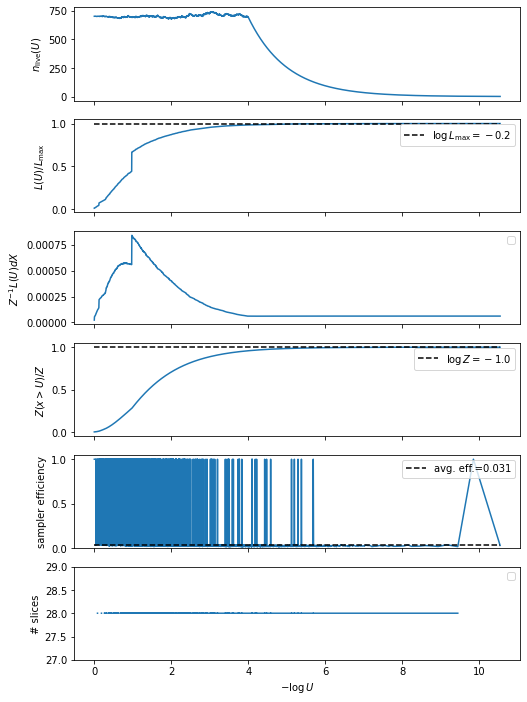

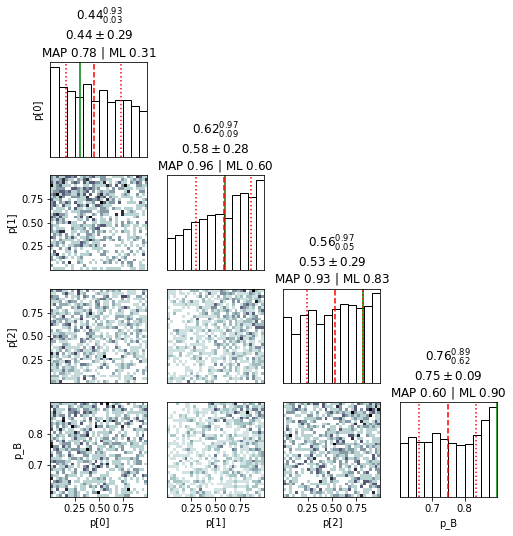

In [4]:
# Inspect results
summary(results)
plot_diagnostics(results)
plot_cornerplot(results, vars=['p', 'p_B'])